In [1]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import math

from neurodsp import filt
from scipy import signal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


dr = '/Users/colinwageman/Desktop/DESKTOP/School/Cogs199/Recordings/odd_ball/'
file = 'run_02.xdf'


data, header = pyxdf.load_xdf(dr+file)

In [2]:
# =====================
# Re Reference all data
# =====================
def re_reference(session_data, new_ref_ch_idx):
    # returns data with the new reference channel removed... because its zeros
    new_ref = session_data[:,new_ref_ch_idx]
    re_referenced = session_data - new_ref[:,None]
    re_referenced = np.delete(re_referenced, new_ref_ch_idx, axis=1)
    
    return re_referenced

# =====================
# Epochs and windowing
# =====================
def ms_to_samples(duration, rate=250):
    return int((duration/1000.0) * rate)

def get_samples_for_t_range(time_series, time_stamps, t_range, inclusive=False):
    # great for grabbing a window
    if inclusive:
        low_filt = time_stamps >= t_range[0]
    else:
        low_filt = time_stamps > t_range[0]
        
    high_filt = time_stamps < t_range[1]
    index_range = low_filt == high_filt
    data_range = time_series[index_range]
    ts_range = time_stamps[index_range]
    return data_range, ts_range

def get_epoch(data, data_times, stim_time, pre_stim_ms, post_stim_ms, sample_rate):
    # great for grabbing around a stimulus event time.
    
    # TODO: is there a faster way?
    i = (np.abs(data_times - stim_time)).argmin()
    start = i - ms_to_samples(pre_stim_ms, sample_rate)
    stop = i + ms_to_samples(post_stim_ms, sample_rate) + 1
    epoch = data[start:stop]
    
    return epoch


# ==========
# Epoch Prep
# ==========
def dc_offset(epoch_data, sample_rate):
    # epoch_data should be 2D, (samples, channels)
    offset = np.mean(epoch_data, 0)

    return epoch_data - offset


def filter_eeg(epoch_data, sample_rate, f_range):
    # epoch_data should be 2D, (samples, channels)
    nyq = 0.5 * sample_rate
    low_limit = f_range[0] / nyq
    high_limit = f_range[1] / nyq
    
    sos = signal.butter(2, [low_limit, high_limit], btype='bandpass', output='sos')
    sig_filt = signal.sosfiltfilt(sos, epoch_data, axis=0)    
    
    return np.array(sig_filt)

def baseline_center(epoch_data, baseline_duration_ms, sample_rate):
    # epoch_data should be 2D, (samples, channels)
    baseline_samples = ms_to_samples(baseline_duration_ms, sample_rate)
    pre_stimulus = epoch_data[:baseline_samples]
    baseline = np.mean(pre_stimulus, 0)
    
    return epoch_data - baseline


def prepare_epochs(epochs, sample_rate):
    # epochs should be 3D, (event, samples, channels)
    
    # frequency range for bandpass filter, in Hz
    LOWCUT = 0.1
    HIGHCUT = 15.0
    freq_range = [LOWCUT,HIGHCUT]
    
    # baseline duration, in ms
    baseline_duration = 100
    
    prepped = []
    for epoch in epochs:
        temp_data = dc_offset(epoch, sample_rate)
#         temp_data = filter_eeg(temp_data, sample_rate, freq_range)
        temp_data = baseline_center(temp_data, baseline_duration, sample_rate)
        prepped.append(temp_data)
        
    return np.array(prepped)


def plot_time_series(X, Y, labels, xlabel=None, ylabel=None, title=None, fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)

    for i in range(len(Y.T)):
        y = Y[:,i]
        ax.plot(X, y, label=labels[i])
        
    xlabel = xlabel if xlabel is not None else 'Time'
    ylabel = ylabel if ylabel is not None else 'Amplitude'
    title = title if title is not None else 'Time Series'
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    _ = ax.legend()
    
    return fig, ax

def add_markers_to_plot(markers, time_stamps, fig, ax):
    for timestamp, marker in zip(time_stamps, markers):
            if (marker[0] == '1'):
                ax.axvline(x=timestamp, color='C1')
            else:
                ax.axvline(x=timestamp, color='C2')

In [3]:
for i, stream in enumerate(data):
    print(str(i),'-', stream['info']['name'][0],'\n')

0 - eeg_data 

1 - aux_data 

2 - P300_Markers 



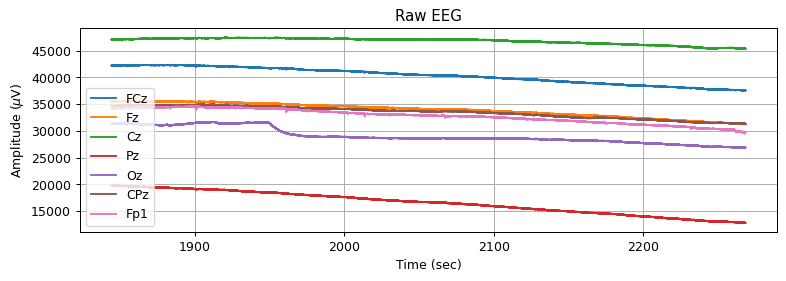

In [4]:
channels = ['ref', 'FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz', 'Fp1']

eeg_data = data[0]['time_series']
eeg_ts = data[0]['time_stamps']
sample_rate = float(data[0]['info']['nominal_srate'][0])

fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)

for i in range(len(channels)):
    if i == 0:
        continue
    y = eeg_data[:,i]
    ax.plot(eeg_ts, y, label=channels[i])
    
ax.set_xlabel('Time (sec)')
ax.set_ylabel(r'Amplitude ($\mu$V)')
ax.set_title('Raw EEG')
ax.grid(True)
_ = ax.legend()

In [5]:
channels = ['ref', 'FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz', 'Fp1']
aux_chs = ['aux ch_1', 'aux ch_2', 'aux ch_3']
SAMPLE_RATE = 250 # Hz

r1_eeg = data[0]['time_series']
r1_eeg_org = data[0]['time_series']
r1_eeg_ts = data[0]['time_stamps']
r1_aux = data[1]['time_series']
r1_aux_ts = data[1]['time_stamps']
r1_markers = data[2]['time_series']
r1_markers_ts = data[2]['time_stamps']

new_ref_ch_idx = 0
r1_eeg = re_reference(r1_eeg, new_ref_ch_idx)
del channels[new_ref_ch_idx]

r1_eeg = filter_eeg(r1_eeg, SAMPLE_RATE, [0.1,15] )
r1_eeg_org = filter_eeg(r1_eeg_org, SAMPLE_RATE, [0.1,15] )

# remove Fp1 channel
r1_eeg = np.delete(r1_eeg, -1, axis=1)
del channels[-1]

print(channels)
pz = channels.index('Pz')

['FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz']


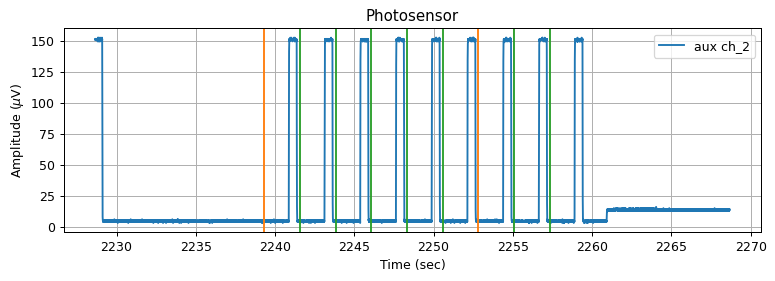

In [6]:
# print(len(r1_aux_ts))
fig, ax = plot_time_series(
    X = r1_aux_ts[-10000:],
    Y = r1_aux[-10000:,1:2],
    labels = aux_chs[1:2],
    xlabel='Time (sec)',
    ylabel=r'Amplitude ($\mu$V)',
    title='Photosensor'
)
add_markers_to_plot(r1_markers[-9:], r1_markers_ts[-9:], fig, ax)

In [7]:
# clean and prep aux channel 0010010
# get associated markers and time stamps
# get trials of markers and time stamps
def get_ts_for_on_rise_threshold(data, data_ts, threshold):
    thr = (data > threshold) + 0
    rise = thr[1:] > thr[:-1]
    rise = np.insert(rise, 0, False) # accounts for lost position above
    return data_ts[rise]

PHOTO_SENSOR_THRESHOLD = 70 # this is based on a visual plot.
r1_photosensor_onsets = get_ts_for_on_rise_threshold(r1_aux[:,1], r1_aux_ts, PHOTO_SENSOR_THRESHOLD)

# graphical blink at the very beginning of run 2 that needs to be removed.
# r1_photosensor_onsets = r1_photosensor_onsets[1:]

r1_y = np.array(r1_markers)[:,0].astype('int')
print(r1_y)
print(r1_photosensor_onsets[-3], r1_y[-3], r1_markers_ts[-3])

print(r1_photosensor_onsets.shape, r1_y.shape)

[0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1
 0 0]
2254.390586281471 1 2252.8199703832297
(150,) (150,)


In [8]:
# Epoch durations in ms
PRE_STIM = 250
POST_STIM = 800

# Make Epochs
r1_epochs = []
for time in r1_photosensor_onsets:
    # get epoch based on time stamp
    epoch = get_epoch(r1_eeg, r1_eeg_ts, time, PRE_STIM, POST_STIM, SAMPLE_RATE)
    r1_epochs.append(epoch)

# Prep Epochs
r1_epochs = prepare_epochs(r1_epochs, SAMPLE_RATE)
print(r1_epochs.shape)

(150, 263, 6)


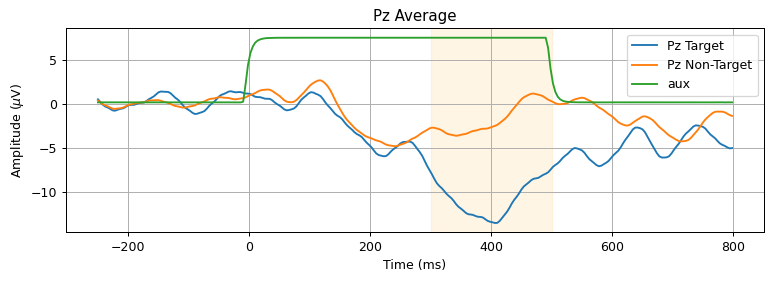

In [12]:
r1_aux_epochs = []
for time in r1_photosensor_onsets:
    # get epoch based on time stamp
    epoch = get_epoch(r1_aux, r1_aux_ts, time, PRE_STIM, POST_STIM, SAMPLE_RATE)
    r1_aux_epochs.append(epoch)

r1_aux_epochs = np.array(r1_aux_epochs) * 0.05
    
target_epochs = r1_epochs[r1_y == 1]
non_target_epochs = r1_epochs[r1_y == 0]

x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(r1_epochs.shape[1])]

# average over epochs
Pz_target_epoch_avg = np.mean(target_epochs[:,:,pz], axis=0)
Pz_non_target_epoch_avg = np.mean(non_target_epochs[:,:,pz], axis=0)

aux_epoch_avg = np.mean(r1_aux_epochs[:,:,1], axis=0)

Pz_avg = np.vstack((Pz_target_epoch_avg, Pz_non_target_epoch_avg, aux_epoch_avg)).T

fig, ax = plot_time_series(
    x_for_plot,
    Pz_avg,
    labels = ['Pz Target', 'Pz Non-Target', 'aux'],
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'{channels[pz]} Average'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)


(150, 263, 6) (150, 263, 8)


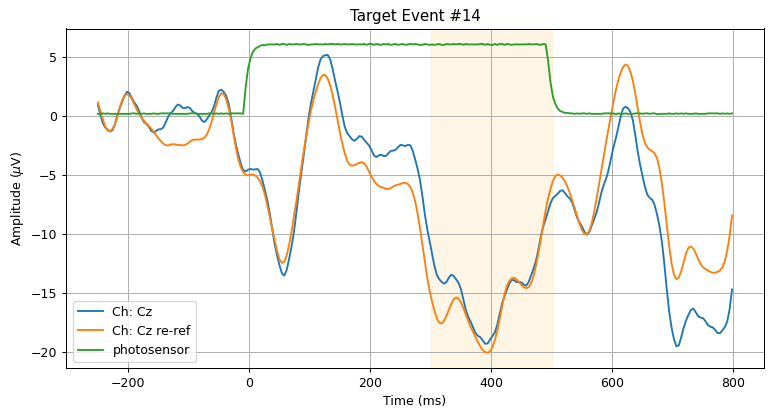

In [10]:
ep_index = 14

# r1_eeg_org
r1_epochs_org = []
for time in r1_photosensor_onsets:
    # get epoch based on time stamp
    epoch = get_epoch(r1_eeg_org, r1_eeg_ts, time, PRE_STIM, POST_STIM, SAMPLE_RATE)
    r1_epochs_org.append(epoch)

r1_epochs_org = prepare_epochs(r1_epochs_org, SAMPLE_RATE)

print(r1_epochs.shape, r1_epochs_org.shape)
test_epoch = r1_epochs[r1_y==1][ep_index]
test_epoch = test_epoch[:,pz-1]
test_epoch_before = r1_epochs_org[r1_y==1][ep_index]
test_epoch_before = test_epoch_before[:,3]

# test_epoch_before = odd_stim_epochs[ep_index][0][:,ch_i]
# test_epoch = odd_stim_epochs[ep_index][0]
# test_epoch = test_epoch[:,ch_i] - test_epoch[:,0]

# baseline_avg = np.mean(test_epoch[0:baseline])

# baseline = ms_to_samples(250)
# baseline_avg_before = np.mean(test_epoch_before[0:baseline])
# test_epoch = test_epoch - baseline_avg
# test_epoch_before = test_epoch_before - baseline_avg_before
test_x = [(i*4)-250 for i in range(len(test_epoch))]

fig, ax = plt.subplots(figsize = (10, 5), dpi = 90)

ax.axvspan(300, 500, color='orange', alpha=0.1)
ax.plot(test_x, test_epoch, label=f'Ch: {channels[pz-1]}')
ax.plot(test_x, test_epoch_before, label=f'Ch: Cz re-ref')
ax.plot(test_x, r1_aux_epochs[r1_y==1][ep_index][:,1]*0.2, label='photosensor')
    
ax.set_xlabel('Time (ms)')
ax.set_ylabel(r'Amplitude ($\mu$V)')
ax.set_title(f'Target Event #{ep_index}')
ax.grid(True)
_ = ax.legend()

In [28]:
def balance_zeros(data, y):
    # truncates the zeros down to the same size as ones.
    # assumes more zeros than ones
    zeros = np.sum(y == 0)
    ones = np.sum(y == 1)
    step = int(zeros/ones)
    print(f'{100*zeros/y.shape[0]:.2f}% zeros')
    sort_order = np.argsort(y, kind='stable')
    half_zeros = [i for i in range(0,zeros,step)]
    sort_order = np.concatenate((sort_order[half_zeros], sort_order[-ones:]), axis=0)
    orig_order = np.sort(sort_order)
    y_part = y[orig_order]
    data_part = data[orig_order]
    
    return data_part, y_part

X_trunc, y_trunc = balance_zeros(r1_epochs, r1_y)
features = X_trunc.shape[-2]
data_set_size = X_trunc.shape[0]
print(f'Classifying with {data_set_size} epochs and {features} features')

X_train, X_test, y_train, y_test = train_test_split(X_trunc[:,:,pz], y_trunc, test_size=0.10, random_state=24)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 10% test split accuracy:', LDA_clf.score(X_test, y_test))
# r1_epochs.shape

80.00% zeros
Classifying with 60 epochs and 263 features
Simple 10% test split accuracy: 0.8333333333333334


In [27]:
def window_and_combine_features(epochs, sub_samples_per_ch):
    # epochs is expected to be 3D, (epoch, sample, channel)
    epoch_len = epochs.shape[1]
    window_len = np.round(epoch_len/sub_samples_per_ch).astype(int)
    windowed = np.zeros(( len(epochs), epochs.shape[-1], sub_samples_per_ch))
    
    for i in range(sub_samples_per_ch):
        win_start = i * window_len
        win_stop = win_start + window_len
        win_avg = np.mean(epochs[:,win_start:win_stop,:], axis=1) # (epochs x ch)
        windowed[:,:,i] = win_avg

    windowed = windowed.reshape((len(epochs), epochs.shape[-1] * sub_samples_per_ch))

    return windowed

X_trunc_win = window_and_combine_features(X_trunc, 5)
features = X_trunc_win.shape[-1]
data_set_size = X_trunc_win.shape[0]
print(f'Classifying with {data_set_size} epochs and {features} features')

X_train, X_test, y_train, y_test = train_test_split(X_trunc_win, y_trunc, test_size=0.10, random_state=24)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 10% test split accuracy:', LDA_clf.score(X_test, y_test))

Classifying with 60 epochs and 30 features
Simple 10% test split accuracy: 0.8333333333333334
